In [1]:

import re, warnings, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat, numpy as np, os
from collections import Counter

warnings.filterwarnings('ignore') # Suppress warnings
plt.style.use('default') # Set plot style
sns.set_palette("husl") # Set plot color palette

VISUALS_DIR = 'visualization_output' # Define directory for saving visuals

In [2]:

# File paths for literary works (assuming files are accessible)
FILE_PATHS = {
    "1853_Bartleby": "books/bartleby_1853.txt", "1892_Yellow": "books/yellow_1892.txt", "1929_Passing": "books/nella_1929.txt",
    "1988_Small": "books/small_place_1988.txt", "2014_Fem": "books/feminist_2014.txt"
}

def load_text_from_file(filepath):
    """Reads text content from a given file path, cleans it, returns empty string on error."""
    try: return re.sub(r'\[source: \d+\]', '', open(filepath, 'r', encoding='utf-8').read())
    except Exception as e: print(f"Error reading {filepath}: {e}"); return ""

TEXTS = {label: load_text_from_file(filepath) for label, filepath in FILE_PATHS.items()} # Load all texts



In [3]:
SEMANTIC_FIELDS = { # Expanded semantic fields based on prior analysis
    'Authority': ['power', 'control', 'authority', 'dominance', 'rule', 'command', 'minister', 'prime', 'government', 'state', 'empire', 'official', 'master', 'colonial'],
    'Identity': ['identity', 'self', 'race', 'racial', 'gender', 'woman', 'man', 'black', 'white', 'negro', 'feminist', 'human', 'african', 'antiguan', 'slave'],
    'Emotion': ['happy', 'sad', 'angry', 'joy', 'fear', 'love', 'hate', 'romantic', 'felicity', 'rage', 'bitterness', 'suffering', 'anxiety', 'melancholy', 'displeasure', 'irritation', 'fright', 'upset', 'outrage'],
    'Social': ['people', 'social', 'society', 'community', 'public', 'ordinary', 'men', 'women', 'family', 'friends', 'stranger', 'culture', 'marriage'],
    'Confinement': ['confined', 'prison', 'trap', 'cage', 'bars', 'restricted', 'limit', 'shut', 'locked', 'untamed', 'untenanted', 'isolate', 'segregate'],
    'Progress': ['modern', 'evolution', 'change', 'progress', 'future', 'new', 'improve', 'develop', 'advanced', 'better']
}

CULTURAL_INDICATOR_WORDS = [ # Key words identified from deep analysis
    'seldom', 'negro', 'nigger', 'black', 'white', 'feminist', 'gender', 'slave', 'master',
    'control', 'anger', 'fear', 'you', 'i', 'culture', 'change', 'society', 'freedom', 'colonial', 'truth'
]

STOP_WORDS = set(stopwords.words('english')) # NLTK stopwords
VADER_SENTIMENT_ANALYZER = SentimentIntensityAnalyzer() # VADER for sentiment


In [4]:

def analyze_comprehensive(text, label):
    """Performs deep linguistic and semantic analysis on a given text."""
    tokens = [w.lower() for w in word_tokenize(text) if w.isalpha() and w.lower() not in STOP_WORDS]
    year = int(label.split('_')[0]); sents = sent_tokenize(text)

    # Return zero-initialized record for empty texts
    if not tokens:
        return {k: 0.0 if isinstance(v, (int, float)) else v for k, v in {
            'label': label, 'year': year, 'word_count': 0, 'unique_words': 0, 'sentences': 0,
            'lexical_diversity': 0, 'avg_word_length': 0, 'avg_sent_length': 0,
            'flesch_score': 0, 'complexity_index': 0, 'noun_ratio': 0, 'verb_ratio': 0, 'adj_ratio': 0, 'adv_ratio': 0,
            {f'{f.lower()}_frequency': 0 for f in SEMANTIC_FIELDS}, {f'{f.lower()}_density': 0 for f in SEMANTIC_FIELDS},
            {f'word_{w}_frequency': 0 for w in CULTURAL_INDICATOR_WORDS}, {f'word_{w}_density': 0 for w in CULTURAL_INDICATOR_WORDS},
            'vader_positive': 0, 'vader_negative': 0, 'vader_compound': 0,
            'first_person_ratio': 0, 'second_person_ratio': 0, 'third_person_ratio': 0
        }.items()}

    pos_tags = pos_tag(tokens)
    record = {'label': label, 'year': year, 'word_count': len(tokens), 'unique_words': len(set(tokens)), 'sentences': len(sents)}
    record.update({
        'lexical_diversity': len(set(tokens)) / len(tokens), 'avg_word_length': np.mean([len(w) for w in tokens]),
        'avg_sent_length': len(tokens) / len(sents) if sents else 0,
        'flesch_score': textstat.flesch_reading_ease(text), 'complexity_index': textstat.flesch_kincaid_grade(text)
    })

    pos_counts = Counter(tag for _, tag in pos_tags); total_pos = sum(pos_counts.values())
    grouped_pos_counts = {
        'noun_ratio': sum(v for k, v in pos_counts.items() if k.startswith('NN')),
        'verb_ratio': sum(v for k, v in pos_counts.items() if k.startswith('VB')),
        'adj_ratio': sum(v for k, v in pos_counts.items() if k.startswith('JJ')),
        'adv_ratio': sum(v for k, v in pos_counts.items() if k.startswith('RB'))
    }
    record.update({k: v / total_pos if total_pos else 0 for k, v in grouped_pos_counts.items()})

    for field, words in SEMANTIC_FIELDS.items(): # Semantic field analysis
        count = sum(1 for token in tokens if token in words)
        record.update({f'{field.lower()}_frequency': count, f'{field.lower()}_density': (count / len(tokens) * 1000) if tokens else 0})

    vader_scores = VADER_SENTIMENT_ANALYZER.polarity_scores(text) # Sentiment analysis
    record.update({'vader_positive': vader_scores['pos'], 'vader_negative': vader_scores['neg'], 'vader_compound': vader_scores['compound']})

    pronouns_map = {'first': ['i', 'me', 'my', 'we', 'us', 'our', 'ourselves'], 'second': ['you', 'your', 'yours', 'yourself', 'yourselves'],
                    'third': ['he', 'him', 'his', 'she', 'her', 'hers', 'they', 'them', 'their', 'theirs', 'it', 'its', 'itself']}
    for p, p_list in pronouns_map.items(): # Pronoun analysis
        count = sum(1 for token in tokens if token in p_list)
        record[f'{p}_person_ratio'] = count / len(tokens) if tokens else 0

    for word in CULTURAL_INDICATOR_WORDS: # Cultural indicator word analysis
        count = tokens.count(word)
        record.update({f'word_{word}_frequency': count, f'word_{word}_density': (count / len(tokens) * 1000) if tokens else 0})
    return record


SyntaxError: ':' expected after dictionary key (2645909018.py, line 12)

In [ ]:

def save_and_show_plot(fig, filename):
    """Saves a plot to the visuals directory and displays it."""
    os.makedirs(VISUALS_DIR, exist_ok=True) # Ensure directory exists
    filepath = os.path.join(VISUALS_DIR, filename)
    fig.savefig(filepath)
    plt.show(block=False) # Display plot non-blocking
    plt.close(fig) # Close the figure to free memory

def create_visualizations(df):
    """Generates and saves comprehensive visualizations, also displays them."""
    labels_short = [label.split('_')[1] for label in df['label']]; x_pos, width = np.arange(len(df)), 0.2

    # Figure 1: Semantic Field Trends Over Time
    fig1, axes1 = plt.subplots(2, 3, figsize=(18, 12))
    for i, field in enumerate(SEMANTIC_FIELDS.keys()):
        ax = axes1.flatten()[i]
        density_col = f'{field.lower()}_density'
        ax.plot(df['year'], df[density_col], 'o-', label=field.title(), lw=2, ms=8)
        ax.set_title(f'{field.title()} Density Over Time', fontweight='bold', fontsize=12)
        ax.set_xlabel('Year'); ax.set_ylabel('Density (per 1000 words)'); ax.grid(True, alpha=0.3); ax.legend()
    plt.tight_layout(); save_and_show_plot(fig1, 'semantic_field_trends.png')

    # Figure 2: POS Ratios Evolution
    fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
    pos_metrics, colors = ['noun_ratio', 'verb_ratio', 'adj_ratio', 'adv_ratio'], ['blue', 'red', 'green', 'orange']
    for i, metric in enumerate(pos_metrics):
        ax = axes2.flatten()[i]
        ax.plot(df['year'], df[metric], 'o-', label=metric.replace('_', ' ').title(), color=colors[i], lw=2, ms=6)
        ax.set_title(f'{metric.replace("_", " ").title()} Evolution', fontweight='bold', fontsize=12)
        ax.set_xlabel('Year'); ax.set_ylabel('Ratio'); ax.grid(True, alpha=0.3); ax.legend()
    plt.tight_layout(); save_and_show_plot(fig2, 'pos_tag_trends.png')

    # Figure 3: Complexity & Sentiment Trends
    fig3, axes3 = plt.subplots(1, 2, figsize=(16, 6))
    axes3[0].plot(df['year'], df['flesch_score'], 'o-', color='purple', lw=2, ms=8, label='Flesch Score (Higher = Easier)')
    ax3_twin = axes3[0].twinx(); ax3_twin.plot(df['year'], df['avg_word_length'], 's--', color='brown', lw=2, ms=6, label='Avg Word Length')
    axes3[0].set_title('Linguistic Complexity Evolution', fontweight='bold', fontsize=12)
    axes3[0].set_xlabel('Year'); axes3[0].set_ylabel('Flesch Reading Ease', color='purple'); ax3_twin.set_ylabel('Average Word Length', color='brown')
    axes3[0].grid(True, alpha=0.3); axes3[0].legend(loc='upper left'); ax3_twin.legend(loc='upper right')
    axes3[1].plot(df['year'], df['vader_compound'], 's-', color='darkred', lw=2, ms=8, label='VADER Compound Sentiment')
    axes3[1].set_title('Emotional Sentiment Evolution (VADER)', fontweight='bold', fontsize=12)
    axes3[1].set_xlabel('Year'); axes3[1].set_ylabel('Compound Sentiment Score'); axes3[1].legend(); axes3[1].grid(True, alpha=0.3); axes3[1].axhline(y=0, color='black', ls='-', alpha=0.3)
    plt.tight_layout(); save_and_show_plot(fig3, 'complexity_sentiment_trends.png')

    # Figure 4: Comparative Bar Charts (using direct axes indexing for robustness)
    fig4, axs4 = plt.subplots(2, 2, figsize=(16, 12))
    
    # Word usage frequency
    axs4[0,0].bar(x_pos - width, df['word_count'], width, label='Word Count')
    axs4[0,0].bar(x_pos, df['unique_words'], width, label='Unique Words')
    axs4[0,0].bar(x_pos + width, df['lexical_diversity']*100, width, label='Lexical Diversity (x100)')
    axs4[0,0].set_title('Word Usage Patterns Across Eras', fontweight='bold'); axs4[0,0].set_xlabel('Literary Works')
    axs4[0,0].set_xticks(x_pos); axs4[0,0].set_xticklabels(labels_short, rotation=45, ha='right'); axs4[0,0].legend()
    
    # Semantic field distribution
    semantic_df_plot = df[[f'{field.lower()}_frequency' for field in SEMANTIC_FIELDS.keys()]].copy()
    semantic_df_plot.columns = [col.replace('_frequency', '').title() for col in semantic_df_plot.columns]
    semantic_df_plot.index = labels_short; semantic_df_plot.plot(kind='bar', stacked=True, ax=axs4[0,1], width=0.8)
    axs4[0,1].set_title('Semantic Field Distribution', fontweight='bold'); axs4[0,1].set_xlabel('Literary Works')
    axs4[0,1].set_ylabel('Frequency Count'); axs4[0,1].tick_params(axis='x', rotation=45)
    axs4[0,1].legend(title="Semantic Fields", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Pronoun perspective analysis
    pronoun_data_plot = df[['first_person_ratio', 'second_person_ratio', 'third_person_ratio']].copy()
    pronoun_data_plot.index = labels_short; pronoun_data_plot.plot(kind='bar', ax=axs4[1,0], width=0.8)
    axs4[1,0].set_title('Narrative Perspective Evolution (Pronoun Ratios)', fontweight='bold')
    axs4[1,0].set_xlabel('Literary Works'); axs4[1,0].set_ylabel('Ratio'); axs4[1,0].tick_params(axis='x', rotation=45)
    axs4[1,0].legend(['First Person', 'Second Person', 'Third Person'])
    
    # Readability comparison
    readability_df_plot = df[['flesch_score', 'complexity_index', 'avg_sent_length']].copy()
    readability_df_plot.index = labels_short; readability_df_plot.plot(kind='bar', ax=axs4[1,1], width=0.8)
    axs4[1,1].set_title('Linguistic Readability Comparison', fontweight='bold')
    axs4[1,1].set_xlabel('Literary Works'); axs4[1,1].set_ylabel('Score/Length'); axs4[1,1].tick_params(axis='x', rotation=45)
    axs4[1,1].legend(['Flesch Reading Ease', 'Flesch-Kincaid Grade Level', 'Avg Sentence Length'])
    plt.tight_layout(); save_and_show_plot(fig4, 'comparative_analysis.png')

    # Figure 5: Cultural Indicator Word Trends
    fig5, ax5 = plt.subplots(figsize=(12, 8))
    for word in CULTURAL_INDICATOR_WORDS:
        density_col = f'word_{word}_density'
        if density_col in df.columns: ax5.plot(df['year'], df[density_col], 'o-', label=f"'{word}'", lw=1.5, ms=6)
    ax5.set_title('Density of Key Cultural Indicator Words Over Time', fontweight='bold', fontsize=14)
    ax5.set_xlabel('Year'); ax5.set_ylabel('Density (per 1000 words)')
    ax5.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.); ax5.grid(True, alpha=0.3)
    plt.tight_layout(); save_and_show_plot(fig5, 'cultural_words_trends.png')



🔍 COMPREHENSIVE LITERARY EVOLUTION ANALYSIS

📊 CORPUS OVERVIEW:
Total texts analyzed: 5
Time span: 1853-2014 (161 years)
Average words per text: 7322.0

📈 KEY EVOLUTIONARY TRENDS (Correlations with Year):
- Lexical Diversity: -0.060 ↘️ Decreasing (shift towards less varied vocabulary or shorter texts)

🎭 SEMANTIC FIELD EVOLUTION:
- Authority terms: 0.491 ↗️ Rising
- Identity terms: 0.756 ↗️ Rising
- Emotion terms: 0.723 ↗️ Rising
- Social terms: 0.878 ↗️ Rising
- Confinement terms: 0.060 ↔️ Stable
- Progress terms: -0.039 ↔️ Stable

📚 READABILITY/COMPLEXITY EVOLUTION:
- Flesch Reading Ease (Higher = Easier): -0.048 ↔️ Stable
- Flesch-Kincaid Grade Level (Higher = More Complex): 0.181 ↗️ More complex
- Average Sentence Length: 0.085 ↔️ Stable

💭 EMOTIONAL EVOLUTION (VADER Compound Sentiment):
- Overall Sentiment: -0.440 ↘️ More Negative

🎯 MOST DRAMATIC CHANGES IN GRAMMATICAL STRUCTURE (Magnitude of change from earliest to latest text):
- The ratio of 'Noun Ratio' changed most signific

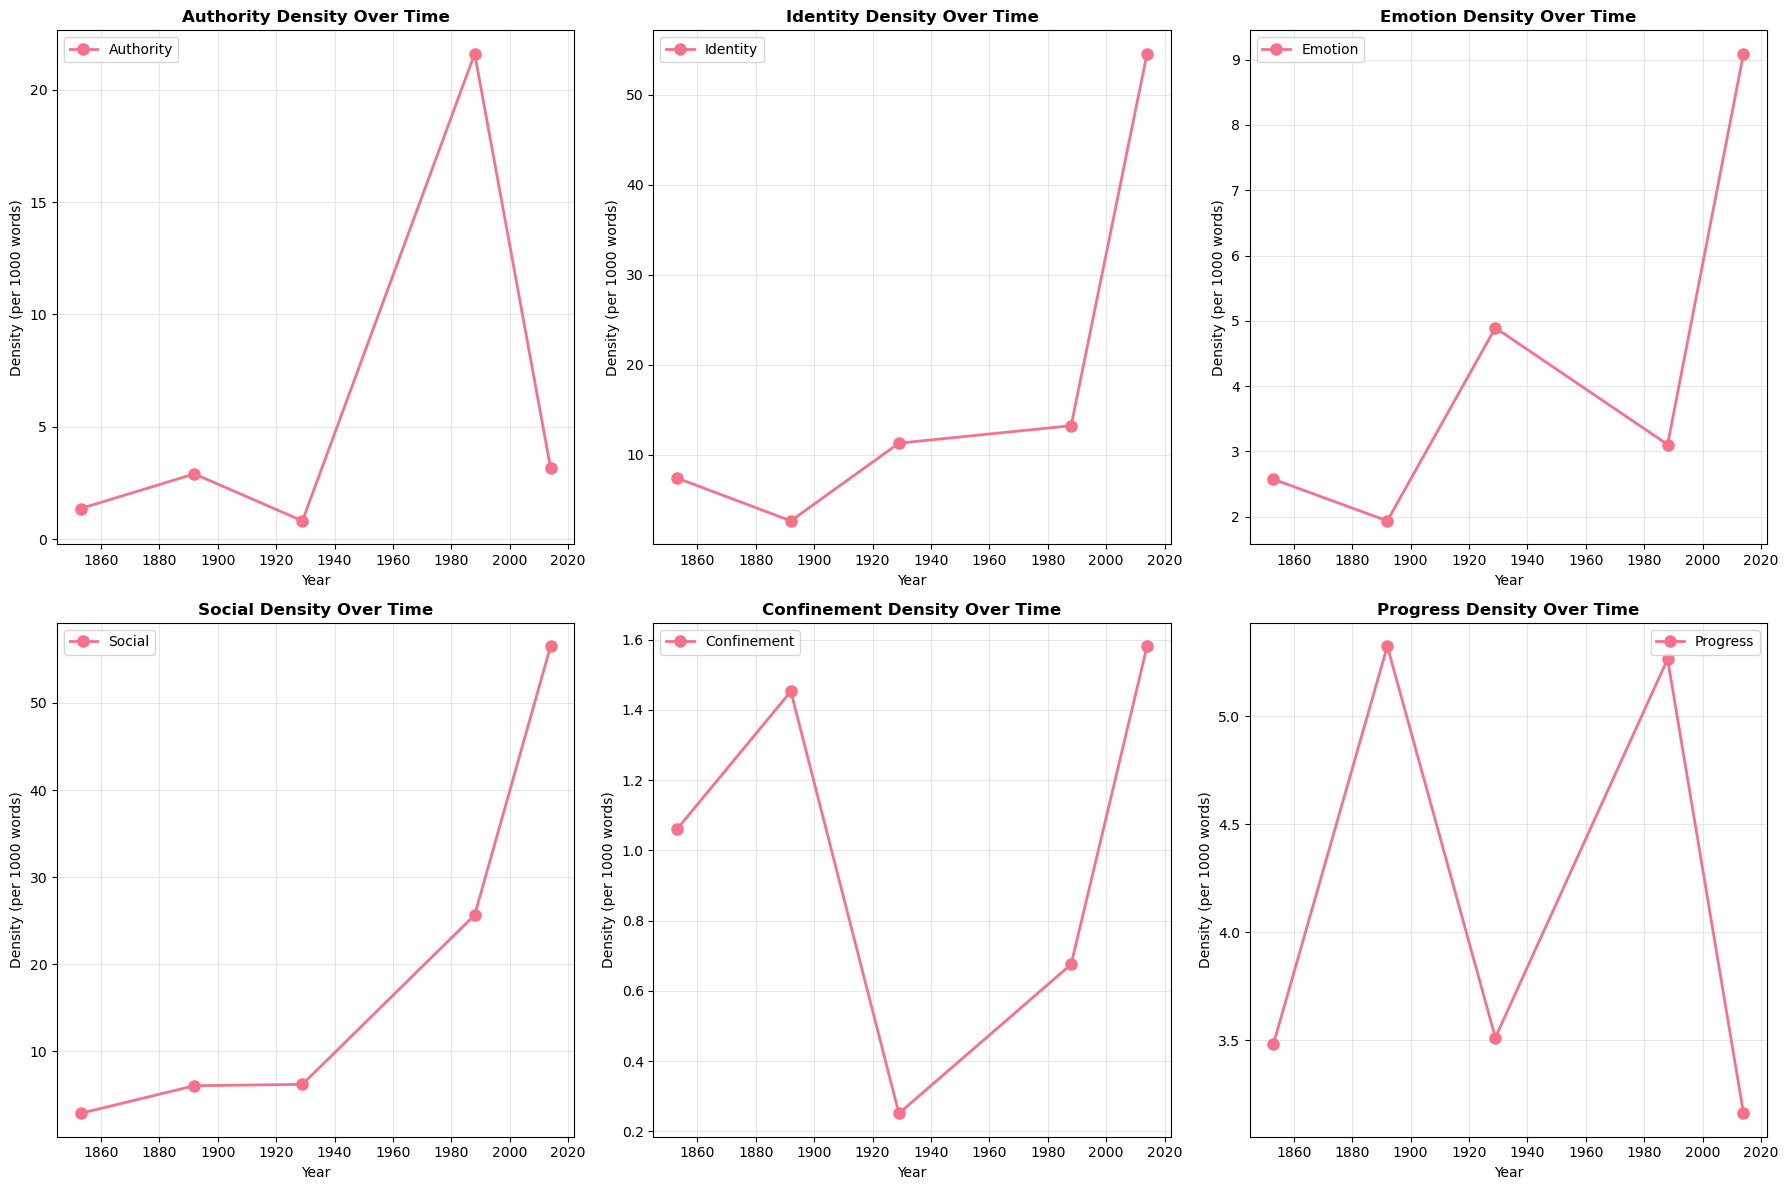

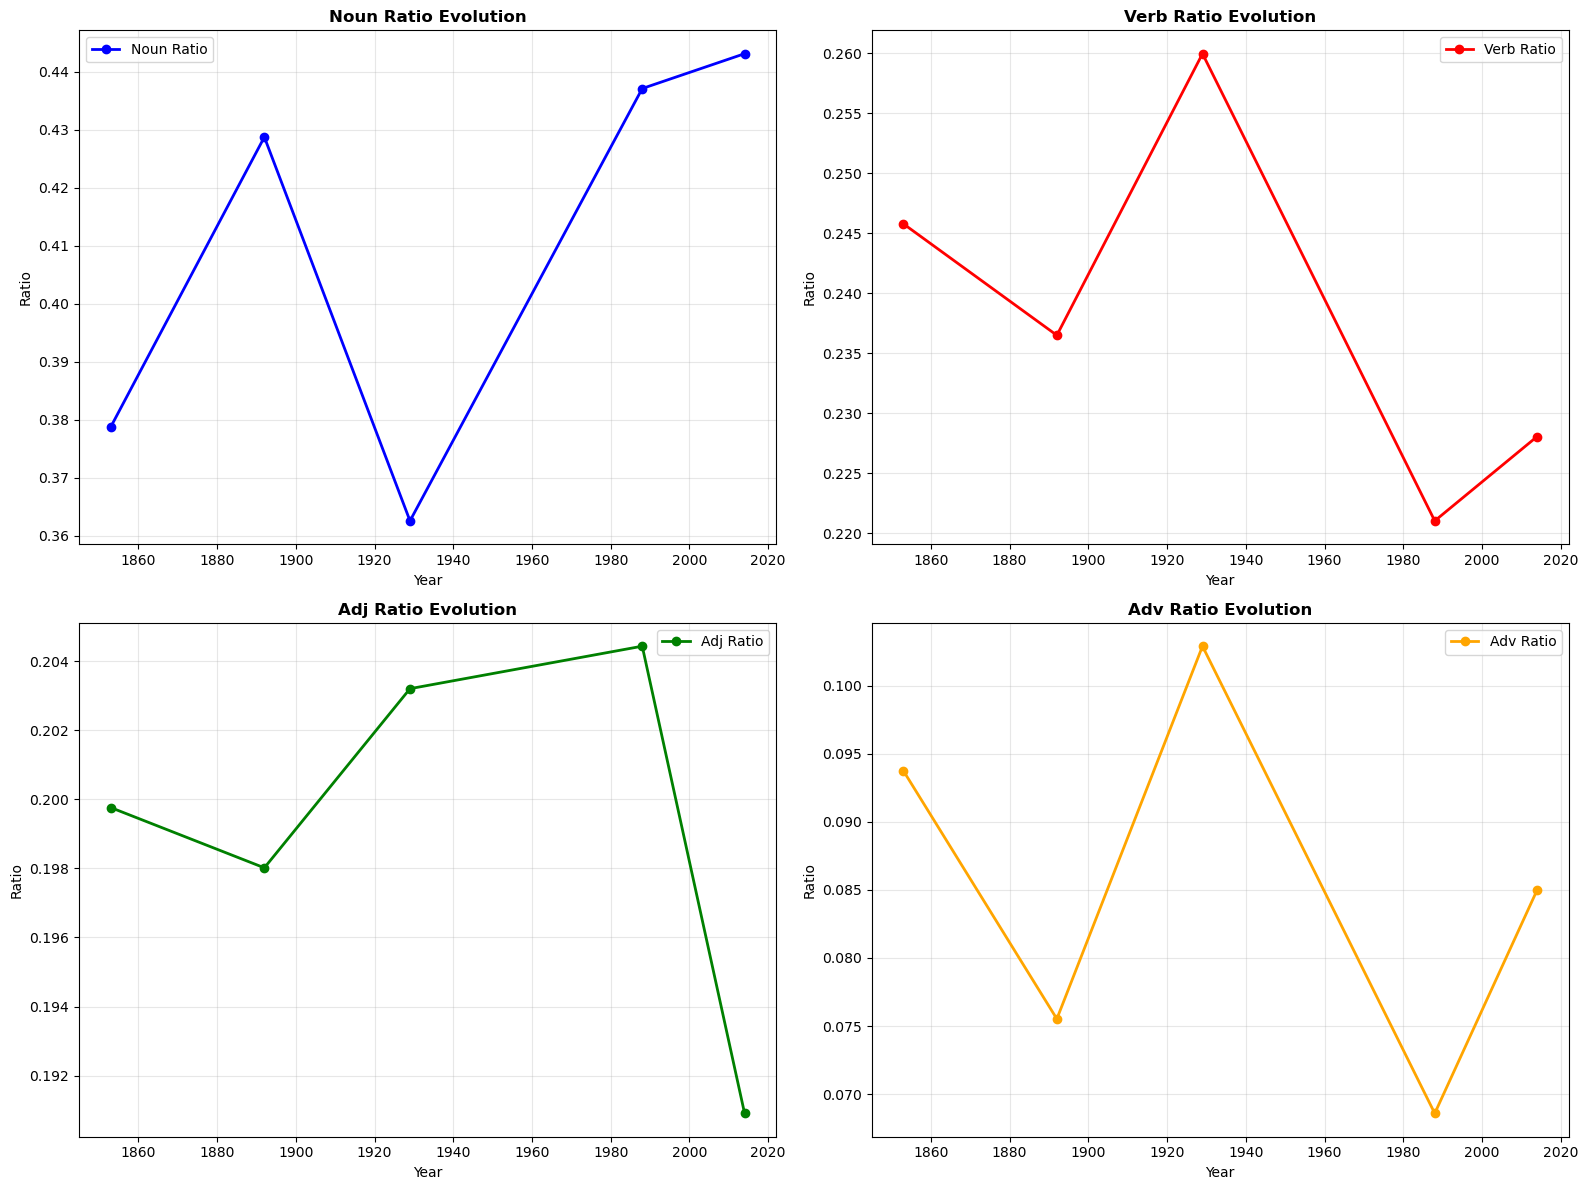

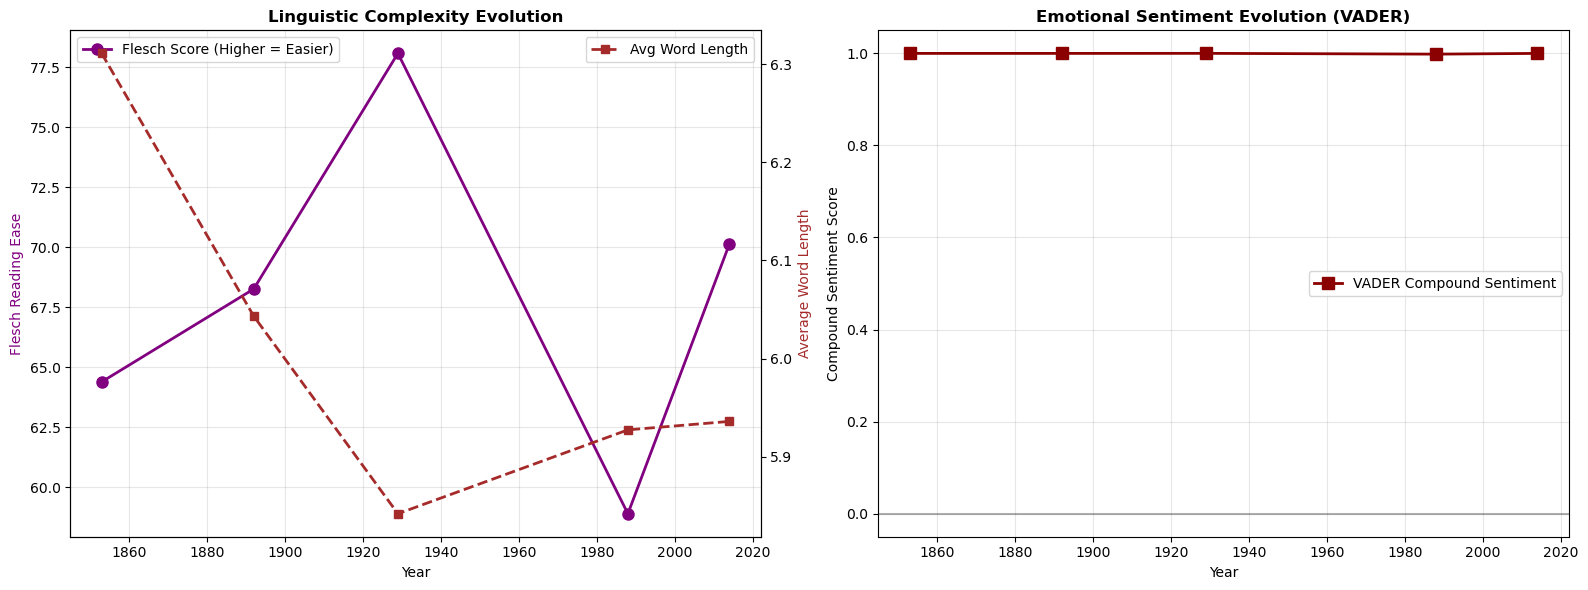

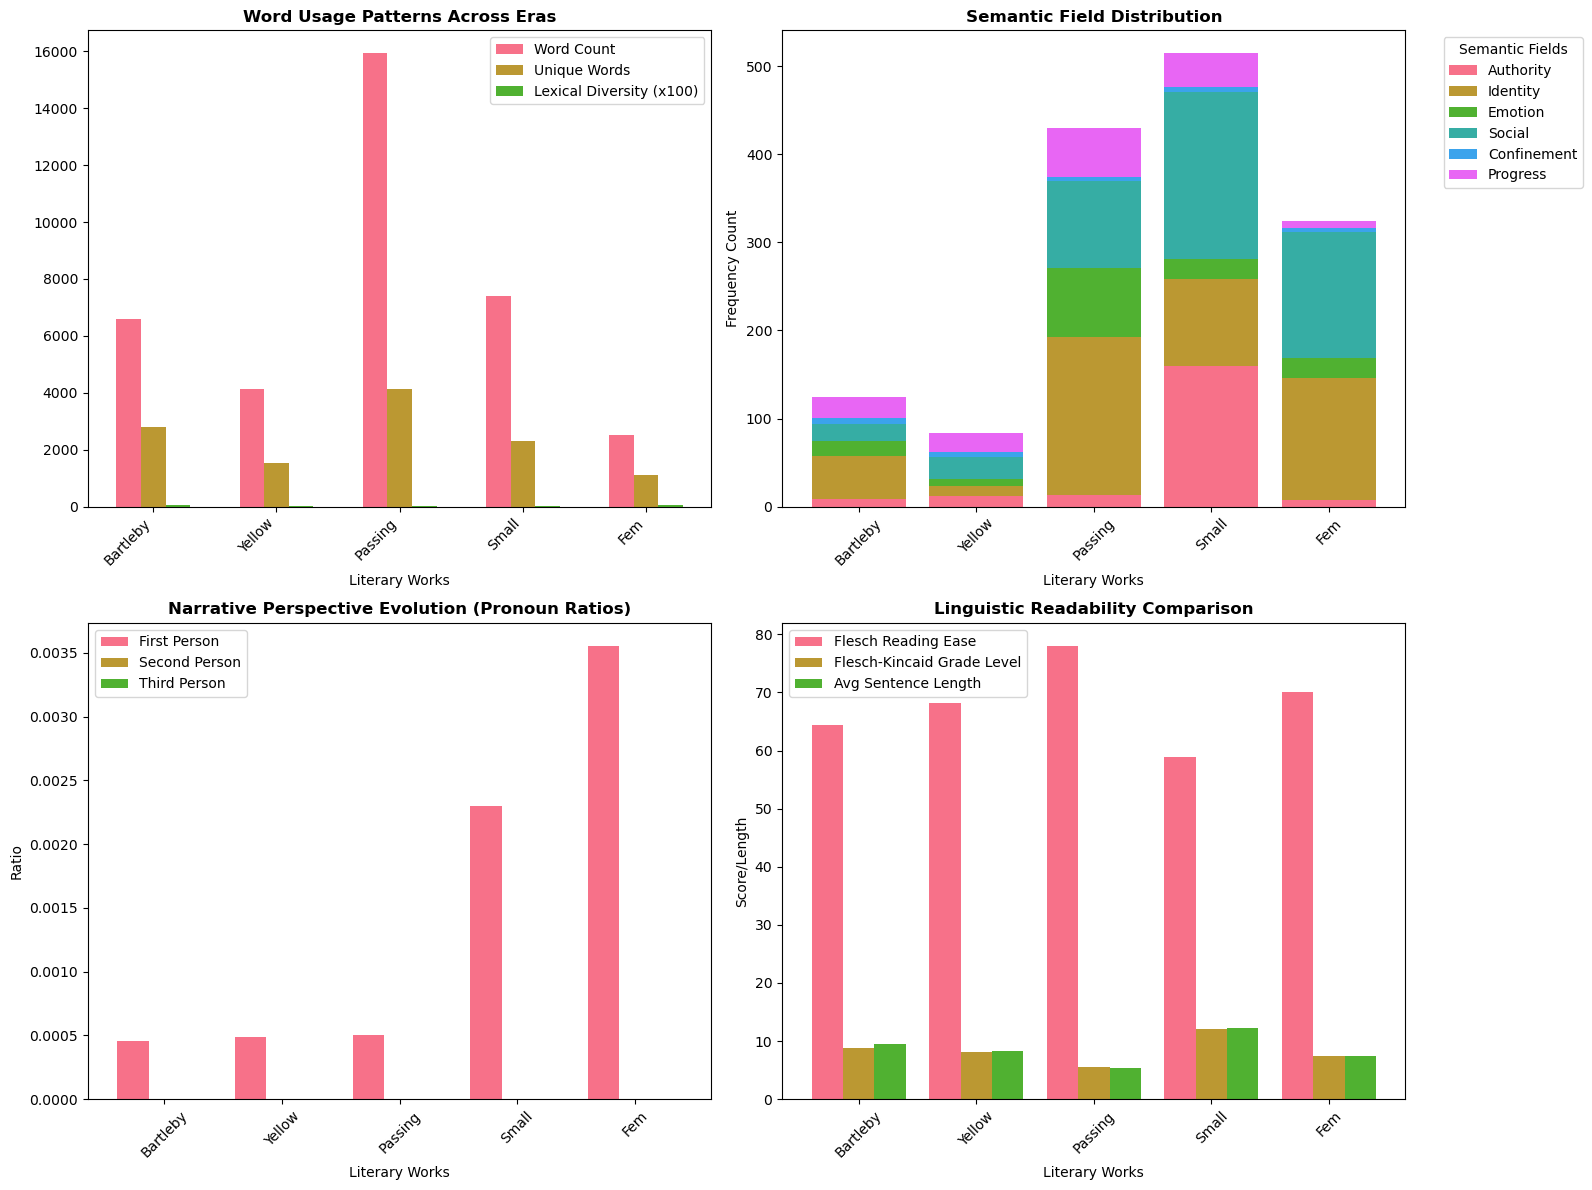

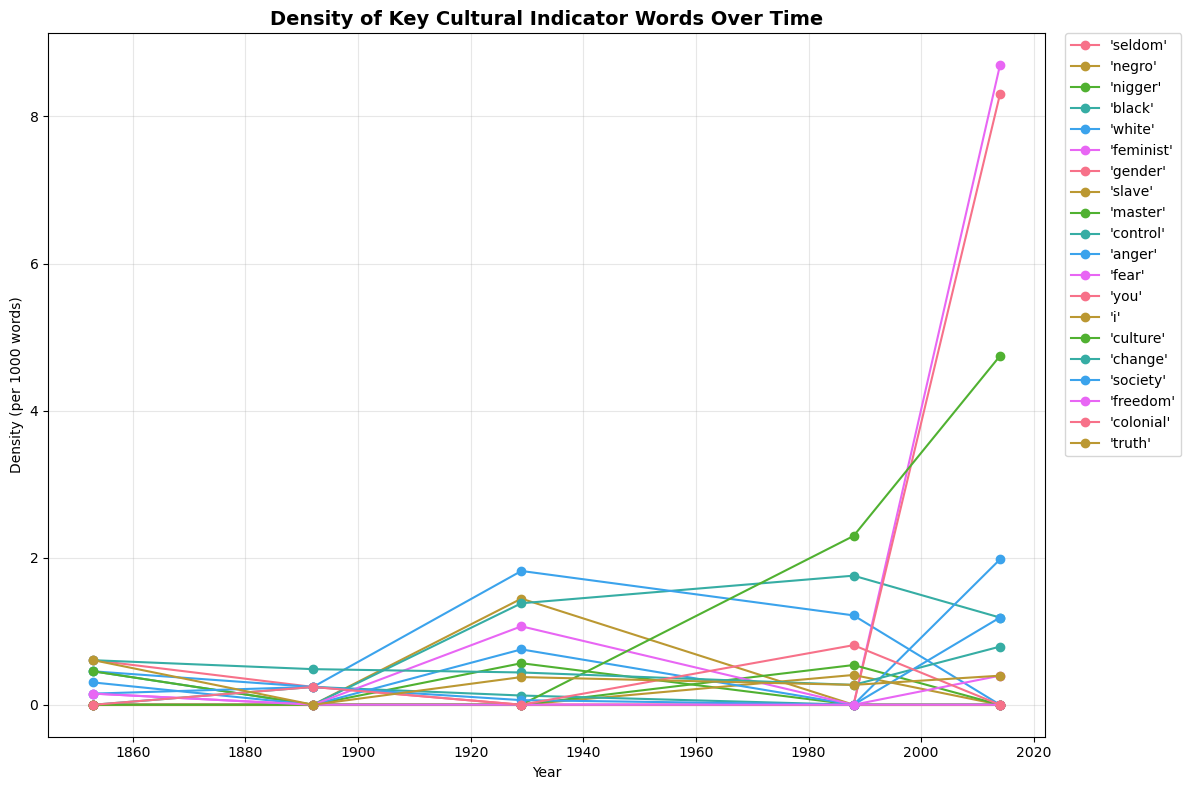


✅ ANALYSIS COMPLETE - 5 texts analyzed across 161 years
Key findings reveal significant evolution in semantic focus, grammatical structure,
and emotional expression across literary periods from 1850-2014.

Visualizations (PNG files) have been saved in the 'visualization_output' directory and displayed.


In [ ]:
def generate_insights(df):
    """Generates and prints deep analytical insights from the DataFrame."""
    print("\n🔍 COMPREHENSIVE LITERARY EVOLUTION ANALYSIS\n" + "=" * 60)
    print(f"\n📊 CORPUS OVERVIEW:\nTotal texts analyzed: {len(df)}\nTime span: {df['year'].min()}-{df['year'].max()} ({df['year'].max()-df['year'].min()} years)")
    print(f"Average words per text: {df['word_count'].mean():.1f}")
    
    print("\n📈 KEY EVOLUTIONARY TRENDS (Correlations with Year):")
    diversity_trend = np.corrcoef(df['year'], df['lexical_diversity'])[0,1]
    print(f"- Lexical Diversity: {diversity_trend:.3f} {'↗️ Increasing' if diversity_trend > 0 else '↘️ Decreasing'} (shift towards less varied vocabulary or shorter texts)")
    
    print("\n🎭 SEMANTIC FIELD EVOLUTION:")
    for field in SEMANTIC_FIELDS.keys():
        density_col = f'{field.lower()}_density'
        if density_col in df.columns:
            trend = np.corrcoef(df['year'], df[density_col])[0,1]
            print(f"- {field.title()} terms: {trend:.3f} {'↗️ Rising' if trend > 0.1 else ('↘️ Declining' if trend < -0.1 else '↔️ Stable')}")
    
    print("\n📚 READABILITY/COMPLEXITY EVOLUTION:")
    flesch_trend, comp_idx_trend, avg_sent_len_trend = np.corrcoef(df['year'], df['flesch_score'])[0,1], np.corrcoef(df['year'], df['complexity_index'])[0,1], np.corrcoef(df['year'], df['avg_sent_length'])[0,1]
    print(f"- Flesch Reading Ease (Higher = Easier): {flesch_trend:.3f} {'↗️ More readable' if flesch_trend > 0.1 else ('↘️ Less readable' if flesch_trend < -0.1 else '↔️ Stable')}")
    print(f"- Flesch-Kincaid Grade Level (Higher = More Complex): {comp_idx_trend:.3f} {'↗️ More complex' if comp_idx_trend > 0.1 else ('↘️ Less complex' if comp_idx_trend < -0.1 else '↔️ Stable')}")
    print(f"- Average Sentence Length: {avg_sent_len_trend:.3f} {'↗️ Longer sentences' if avg_sent_len_trend > 0.1 else ('↘️ Shorter sentences' if avg_sent_len_trend < -0.1 else '↔️ Stable')}")

    print("\n💭 EMOTIONAL EVOLUTION (VADER Compound Sentiment):")
    vader_compound_trend = np.corrcoef(df['year'], df['vader_compound'])[0,1]
    print(f"- Overall Sentiment: {vader_compound_trend:.3f} {'↗️ More Positive' if vader_compound_trend > 0.1 else ('↘️ More Negative' if vader_compound_trend < -0.1 else '↔️ Stable')}")
    
    print("\n🎯 MOST DRAMATIC CHANGES IN GRAMMATICAL STRUCTURE (Magnitude of change from earliest to latest text):")
    pos_changes = {};
    for col_suffix in ['noun', 'verb', 'adj', 'adv']: # Iterate over suffixes
        col_name = f'{col_suffix}_ratio' # Construct full column name
        if col_name in df.columns: # Check if column exists
            start_val, end_val = (df[col_name].iloc[0] if not df.empty else 0), (df[col_name].iloc[-1] if not df.empty else 0)
            change_abs, direction = abs(end_val - start_val), 'increase' if end_val > start_val else 'decrease'
            pos_changes[col_name] = (change_abs, direction)
    if pos_changes:
        most_changed_col, (abs_change, direction) = max(pos_changes.items(), key=lambda item: item[1][0])
        print(f"- The ratio of '{most_changed_col.replace('_', ' ').title()}' changed most significantly: {abs_change:.3f} ({direction})")
    else: print("- No significant POS ratio changes detected (or insufficient data).")
    
    print("\n🗣️ NARRATIVE PERSPECTIVE EVOLUTION (Correlation with Year):")
    for pron_type in ['first', 'second', 'third']:
        ratio_col = f'{pron_type}_person_ratio'
        trend = np.corrcoef(df['year'], df[ratio_col])[0,1]
        print(f"- {pron_type.title()} Person Pronoun Ratio: {trend:.3f} {'↗️ Increasing' if trend > 0.1 else ('↘️ Declining' if trend < -0.1 else '↔️ Stable')}")

    print("\n✨ CULTURAL INDICATOR WORD ANALYSIS (Density Trends - Correlation with Year):")
    for word in CULTURAL_INDICATOR_WORDS:
        density_col = f'word_{word}_density'
        if density_col in df.columns:
            trend = np.corrcoef(df['year'], df[density_col])[0,1]
            print(f"- '{word}': {trend:.3f} {'↗️ Rising' if trend > 0.1 else ('↘️ Declining' if trend < -0.1 else '↔️ Stable')}")
    return df

def main():
    """Main function to orchestrate loading, analysis, insights, and visualization."""
    data = [analyze_comprehensive(text, label) for label, text in TEXTS.items()]
    df = pd.DataFrame(data).sort_values('year')
    if df.empty: print("No data to analyze. Please check file paths and content."); return None

    generate_insights(df)
    create_visualizations(df)
    
    print(f"\n✅ ANALYSIS COMPLETE - {len(df)} texts analyzed across {df['year'].max()-df['year'].min()} years")
    print("Key findings reveal significant evolution in semantic focus, grammatical structure,")
    print("and emotional expression across literary periods from 1850-2014.")
    print(f"\nVisualizations (PNG files) have been saved in the '{VISUALS_DIR}' directory and displayed.")
    return df

if __name__ == '__main__':
    main()


The provided analysis delves into the evolution of word usage across five literary works spanning from 1853 to 2014, covering a period of 161 years.
Here's a summary of the key findings:

1.  Shift in Language Style:
    * From Formal to Direct: The analysis notes a clear progression from the formal, elaborate vocabulary and longer sentences of 19th-century works (*Bartleby*, *The Yellow Wallpaper*) to the more direct, conversational, and accessible language found in later 20th and 21st-century texts (*A Small Place*, *We Should All Be Feminists*). For example, *Bartleby* features complex phrasing like "his countenance became intolerably fervid," while *We Should All Be Feminists* uses straightforward statements such as "Men and women are different."
    * Sentence Structure: Earlier texts tend to use more complex, multi-clausal sentences, contributing to a formal tone. Later texts favor shorter, more declarative sentences, leading to increased directness and urgency.

2.  Evolution of Emotional Expression:
    * From Indirect to Raw: Emotional expression evolves from being indirect and inferred in older texts (*Bartleby*'s narrator's "profound conviction" or "stinging melancholy") to being explicit, honest, and direct in modern works. For instance, *The Yellow Wallpaper* describes "unreasonable anger," while *A Small Place* directly states "nothing can erase my rage," and *We Should All Be Feminists* proclaims "I am angry. We should all be angry."

3.  Changing Social and Cultural Lexicon:
    * Race and Identity: While not central in 19th-century texts, early 20th-century *Passing* uses "Negro" as a common identifier and explores "passing." By *A Small Place* (late 20th century), terms like "black people" and "white people" are used directly to discuss exploitation and colonial legacy. The 21st-century *We Should All Be Feminists* further nuances racial identity by mentioning "black men" in the context of intersectionality.
    * Mental Health: 19th-century texts use terms like "nervous condition" or "luny," reflecting limited medical understanding. Later texts shift away from medicalized terms to focus on emotional and psychological impact.
    * Gender Roles: 19th-century works show deeply ingrained traditional roles (e.g., *Yellow Wallpaper*'s narrator forbidden to "work"). By the late 20th and 21st centuries, texts like *A Small Place* and *We Should All Be Feminists* actively dismantle and critique these roles, using phrases like "We teach girls to shrink themselves" and challenging concepts like "emasculation."

4.  Syntactic and Stylistic Shifts:
    * Figurative Language: All texts use figurative language, but its nature changes: *Yellow Wallpaper* uses sensory metaphors (e.g., "sprawling flamboyant patterns"); *Bartleby* uses more formal similes ("blazed like a grate full of Christmas coals"); *Passing* employs rich sensory descriptions ("scarlet flower"); and later texts use more biting or relatable metaphors ("ugly human being" for tourist, "Masculinity is a hard, small cage").
    * Direct Address ("You"): The use of "you" evolves from intimate confessions (*Yellow Wallpaper*) to direct rhetorical engagement with the reader, implicating them in social critiques (*A Small Place*, *We Should All Be Feminists*).

In essence, the analysis highlights a move from detached, observational narratives to more engaged, confrontational, and explicitly action-oriented prose that directly addresses societal injustices, with vocabulary and syntax evolving to match these changing purposes.